In [1]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

sys.path.insert(0, '../../')
import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'../../lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'

import torch
from torch.nn.functional import conv1d, mse_loss
from torchcontrib.optim import SWA

from tqdm import tqdm
import mir_eval

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [3]:
# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 15, 'pin_memory': True, 'worker_init_fn': worker_init}

In [4]:
start = time()
root = '../../../data/'
train_set = musicnet.MusicNet(root=root, epoch_size=100000
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=0, jitter=.0)
test_set = musicnet.MusicNet(root=root, train=False, download=True, refresh_cache=False, window=window, epoch_size=50000, mmap=False)
print("Time used = ", time()-start)

Time used =  34.13013458251953


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [6]:
def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, sr=44100, freq_scale='linear', mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    

    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        
    if freq_scale == 'linear':
        start_bin = start_freq*n_fft/sr
        scaling_ind = (end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
    elif freq_scale == 'log':
        start_bin = start_freq*n_fft/sr
        scaling_ind = np.log(end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)    
    else:
        print("Please select the correct frequency scale, 'linear' or 'log'")
    
    return wsin,wcos


In [7]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [8]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, low=50, high=6000,
                                      mode="stft", freq_scale='log')
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, k,bias=False)
        self.linear_output = torch.nn.Linear(k,m, bias=False)
        wscale = 10e-5
        torch.nn.init.normal_(self.linear.weight, std=1e-4) # initialize
        torch.nn.init.normal_(self.linear_output.weight, std=1e-4)
#         torch.nn.init.zeros_(self.linear.weight)
#         torch.nn.init.zeros_(self.linear_output.weight)
        self.activation = torch.nn.ReLU()
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.cuda().data for parm in self.parameters())) 

        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        zx = self.activation(self.linear(torch.log(zx + 10e-8).view(x.data.size()[0],regions*k)))
        output = self.linear_output(zx)
        return output
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Averaged Weights

In [9]:
model = Model()
model.cuda()

Model(
  (linear): Linear(in_features=12800, out_features=512, bias=False)
  (linear_output): Linear(in_features=512, out_features=128, bias=False)
  (activation): ReLU()
)

In [10]:
loss_history_train = []
avgp_history_train = []
loss_history_test = []
avgp_history_test = []
epochs = 20
avg = .9998
optimizer = torch.optim.SGD(model.parameters(), lr=1.5e-4, momentum=.95)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.FloatTensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"Training {i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
                model.average_iterates() # Averaging the weights for validation
                
            avgp = average_precision_score(yground.flatten(),yhat.flatten())    
            loss_history_train.append(loss_e/len(train_loader))
            avgp_history_train.append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"Testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            loss_history_test.append(loss_e/len(test_loader))
            avgp_history_test.append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         loss_history_train[-1],loss_history_test[-1],
                         avgp_history_train[-1],avgp_history_test[-1],
                         time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 276, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/conda/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().au

RuntimeError: DataLoader worker (pid(s) 2866) exited unexpectedly

(0.3, 0.75)

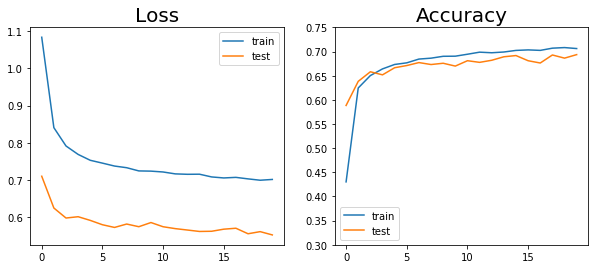

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(loss_history_train)
ax[0].plot(loss_history_test)
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(avgp_history_train)
ax[1].plot(avgp_history_test)
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.75)

# Mirex stats

In [12]:
def get_mir_accuracy(Yhat, Y_true, threshold=0.4):
    Yhatlist = []
    Ylist = []
    Yhatpred = Yhat>threshold
    for i in range(len(Yhatpred)):
        print(f"{i}/{len(Yhatpred)} batches", end = '\r')
        fhat = []
        f = []
        for note in range(m):
            if Yhatpred[i][note] == 1:
                fhat.append(440.*2**(((note)-69.)/12.))

            if Y_true[i][note] == 1:
                f.append(440.*2**(((note)-69.)/12.))

        Yhatlist.append(np.array(fhat))
        Ylist.append(np.array(f))
    avp = average_precision_score(Y_true.flatten(),Yhat.detach().cpu().flatten())
    P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
    mir_eval.multipitch.metrics(np.arange(len(Ylist))/100.,Ylist,np.arange(len(Yhatlist))/100.,Yhatlist)
    print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(100*avp,100*P,100*R,Acc,Etot,Esub,Emiss,Efa))
    return avp,P,R,Acc,Etot
def get_piano_roll(rec_id, window=16384, stride=1000, offset=44100, count=7500):
    sf=4
    if stride == -1:
        stride = (test_set.records[rec_id][1] - offset - int(sf*window))/(count-1)
        stride = int(stride)
    else:
        count = (test_set.records[rec_id][1] - offset - int(sf*window))/stride + 1
        count = int(count)
        
    X = np.zeros([count, window])
    Y = np.zeros([count, m])    
        
    for i in range(count):
        X[i,:], Y[i] =  test_set.access(rec_id, offset+i*stride)
        
    X = torch.tensor(X).float().cuda()
    Y_pred = model(X)
    
    return Y_pred, Y
    

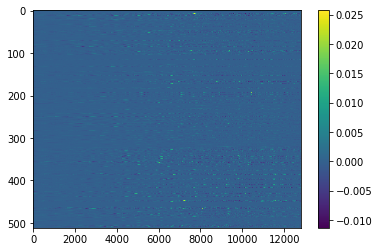

In [13]:
plt.imshow(model.linear.weight.data.cpu(), aspect='auto')
plt.colorbar()

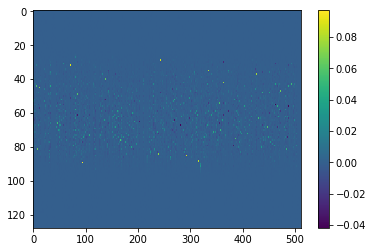

In [14]:
plt.imshow(model.linear_output.weight.data.cpu(), aspect='auto')
plt.colorbar()

In [15]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
75.43	76.20	68.58	0.56	0.41	0.12	0.20	0.10
76.84	73.44	72.40	0.57	0.43	0.11	0.17	0.15
41.51	54.60	37.77	0.29	0.79	0.15	0.48	0.17
70.20	59.69	77.74	0.51	0.67	0.08	0.14	0.45
66.70	62.89	76.52	0.53	0.51	0.17	0.06	0.28
73.98	72.43	64.52	0.52	0.47	0.13	0.23	0.12
66.79	72.47	57.37	0.47	0.52	0.12	0.30	0.10
71.14	67.88	68.92	0.52	0.51	0.13	0.18	0.20
76.43	73.28	67.18	0.54	0.47	0.10	0.23	0.14
70.31	69.40	68.97	0.53	0.48	0.13	0.18	0.17


In [17]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'.format(Accavg*100/len(test_set.rec_ids), Etotavg*100/len(test_set.rec_ids)))

Average Accuracy: 	50.40
Average Error: 		52.70


In [29]:
for songid in [1759]:
    model.eval()
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)

70.72	68.80	72.40	0.55	0.48	0.13	0.15	0.20


In [30]:
from pypianoroll import Multitrack, Track, load, parse

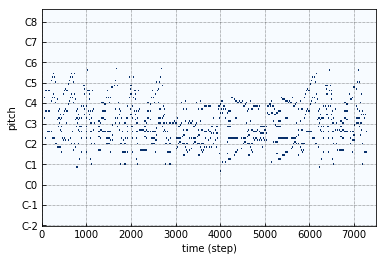

In [83]:
# Create a piano-roll matrix, where the first and second axes represent time
# and pitch, respectively, and assign a C major chord to the piano-roll
# Create a `pypianoroll.Track` instance
track = Track(pianoroll=Y_true*127, program=0, is_drum=False,
              name='my awesome piano')

# Plot the piano-roll
fig, ax = track.plot()

In [87]:
Yhatpred = Y_pred > 0.4

In [88]:
Yhatpred = Yhatpred.cpu().numpy()

In [93]:
def export_midi(Y_pred, path):
    # Create a piano-roll matrix, where the first and second axes represent time
    # and pitch, respectively, and assign a C major chord to the piano-roll
    # Create a `pypianoroll.Track` instance
    track = Track(pianoroll=Y_pred*127, program=0, is_drum=False,
                  name='my awesome piano')   
    multitrack = Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)
    multitrack.write(path)

In [96]:
export_midi(Y_true, './Y_true.mid')

In [101]:
torch.save(model.state_dict(), './weights/Toy_weight')

In [102]:
torch.save(model, './weights/Toy_model_full')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
